<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#GridSearch" data-toc-modified-id="GridSearch-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>GridSearch</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

# Такси
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

***Цель исследования***:
1. Обработать полученные данные
2. Проанализировать полученные данные
3. Обучить разные модели
4. Предложить лучшую модель по качеству предсказания

***Ход исследования***:
1. Получим данные из исходных датасетов
2. Предобработаем данные: удалим пропуски, отсортируем по времни
3. Проведем исследовательский анализ 
4. Подготовим данные для построения модели МО с использованием пайплайнов, рассмотрим несколько моделей и параметров
5. Оценим полученные модели по заданным критериям
6. Сделаем общий вывод по работе, дадим рекомендации сервису по выбору модели

In [1]:
!pip install -q scikit-learn==1.5.0
!pip install --upgrade matplotlib seaborn -q
!pip install lightgbm -q
!pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from IPython.display import Markdown, display
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
sns.set_theme(style="whitegrid")
RANDOM_STATE = 42

### Загрузка данных

In [3]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', sep=",", index_col=[0], parse_dates=[0])
    print('Код выполняется на платформе')
except FileNotFoundError:
    taxi = pd.read_csv('datasets/taxi.csv', sep=",", index_col=[0], parse_dates=[0])
    print('Код выполняется локально')

Код выполняется локально


In [4]:
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi.tail(1)

,num_orders
datetime,
2018-08-31 23:50:00,53


### Предобработка данных

In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
taxi.shape

(26496, 1)

In [8]:
taxi.sort_index(inplace=True)
taxi_season = taxi.copy(deep=True)
taxi = taxi.resample('1H').sum()
taxi.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [9]:
taxi.index.is_monotonic

True

In [10]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Исследовательский анализ данных

In [11]:
taxi['rolling_mean'] = taxi.rolling(100).mean()

Text(0, 0.5, 'Количество заказов')

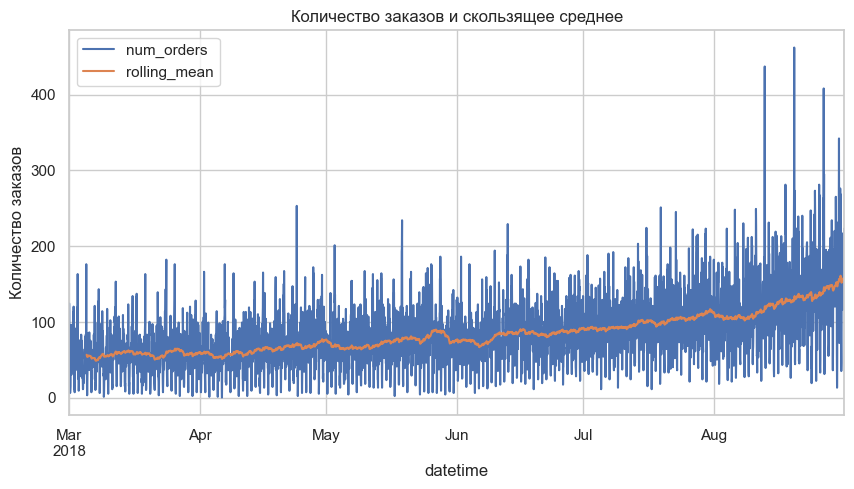

In [12]:
plt.figure(figsize=(10, 5))
taxi.plot(ax=plt.gca())
plt.title('Количество заказов и скользящее среднее')
plt.ylabel('Количество заказов')

Text(0, 0.5, 'Количество заказов')

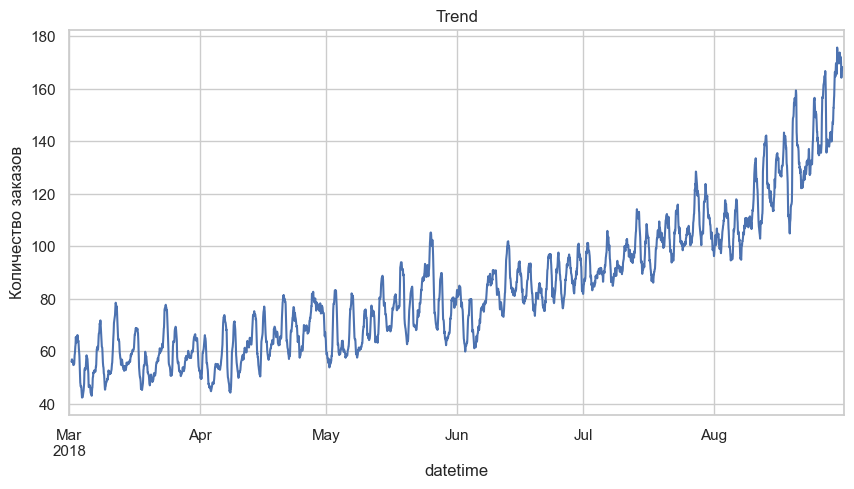

In [13]:
decomposed = seasonal_decompose(taxi['num_orders'])
plt.figure(figsize=(10, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Количество заказов')

Text(0, 0.5, 'Количество заказов')

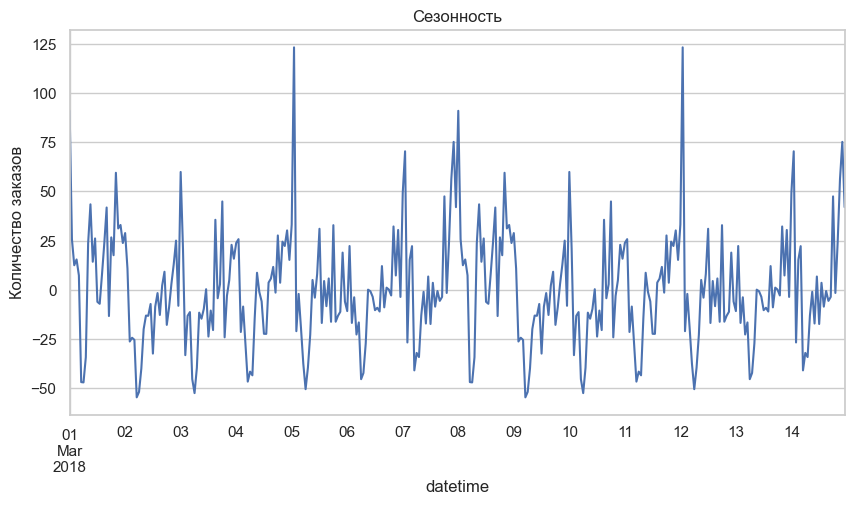

In [14]:
decomposed = seasonal_decompose(taxi['num_orders']['2018-03-01':'2018-03-14'], period=24*7)
plt.figure(figsize=(10, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')

Text(0, 0.5, 'Количество заказов')

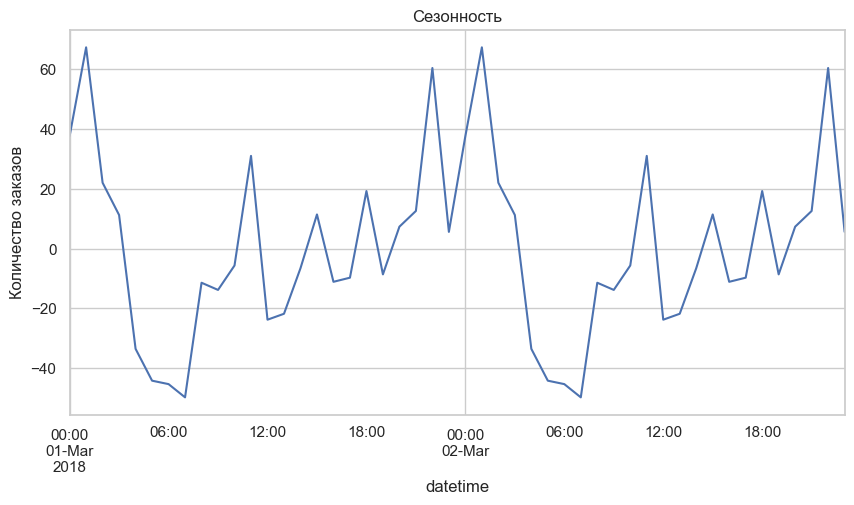

In [15]:
decomposed = seasonal_decompose(taxi['num_orders']['2018-03-01':'2018-03-02'], period=24)
plt.figure(figsize=(10, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(taxi, 10, 5)
taxi.dropna(inplace=True)
taxi.head(3)

,num_orders,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
datetime,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,27.2,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 11:00:00,96,38.8,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 12:00:00,30,55.6,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0


По графикам сезонности видим, что спрос меняется в зависимости от дня недели и часа, в который заказывалось такси. В связи с этим, добавили эти свойства в данные, чтобы лучше строить модель.

### Обучение моделей

In [18]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3965 entries, 2018-03-01 10:00:00 to 2018-08-13 14:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rolling_mean  3965 non-null   float64
 1   hour          3965 non-null   int64  
 2   dayofweek     3965 non-null   int64  
 3   lag_1         3965 non-null   float64
 4   lag_2         3965 non-null   float64
 5   lag_3         3965 non-null   float64
 6   lag_4         3965 non-null   float64
 7   lag_5         3965 non-null   float64
 8   lag_6         3965 non-null   float64
 9   lag_7         3965 non-null   float64
 10  lag_8         3965 non-null   float64
 11  lag_9         3965 non-null   float64
 12  lag_10        3965 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 433.7 KB


#### GridSearch

В данном случае кодировать данные не будем

In [20]:
pipe = Pipeline(
    [
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 

In [21]:
param_grid = [{
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10, None],
        'models__min_samples_split': [2, 3],
        'models__min_samples_leaf': [1, 2]
    },
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE, categorical_feature=[1, 2], verbosity=-1)],
        'models__num_leaves': [5, 15, 31],
        'models__num_boost_round': [100],
        'models__metric': [["l1", "l2"], 'l2', 'l1']
    },
    {
        'models': [LinearRegression()]
    },
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, cat_features=[1, 2], iterations=100)]
    }
] 

In [22]:
start_time = time.perf_counter()

grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=False,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

end_time = time.perf_counter()
time_fit = end_time - start_time
print(time_fit,'c')
grid_search

12.4914206 c


C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\ProgramData\anaconda3\envs\practicum\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\ProgramData\anaconda3\envs\practicum\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\envs\practicum\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.Cre

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('models',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': [5, 10, None],
                          'models__min_samples_leaf': [1, 2],
                          'models__min_samples_split': [2, 3]},
                         {'models': [LGBMRegressor(categorical_feature=[1, 2],
                                                   random_state=42,
                                                   verbosity=-1)],
                          'models__metric': [['l1', 'l2'], 'l2', 'l1'],
                          'models__num_boost_round': [100],
                          'models__num_leaves': [5, 15, 31]},
                         {'models': [LinearRegression()]},
                         {'models': [<catboost.core.CatBoostRegressor object at 0x000002540D2D8B50>]}],
             scoring='neg_root_mean_squared_error', verbose=False)

In [23]:
result = pd.DataFrame(grid_search.cv_results_)
# print(result.columns)
output_result = (result[['mean_fit_time', 'mean_test_score', 'param_models']]
                 .sort_values('mean_test_score', ascending=False))
output_result.head(5)

,mean_fit_time,mean_test_score,param_models
19,1.045690,-23.898732,"LGBMRegressor(categorical_feature=[1, 2], rand..."
16,1.108060,-23.898732,"LGBMRegressor(categorical_feature=[1, 2], rand..."
13,1.606090,-23.898732,"LGBMRegressor(categorical_feature=[1, 2], rand..."
20,1.643591,-24.042875,"LGBMRegressor(categorical_feature=[1, 2], rand..."
17,2.068089,-24.042875,"LGBMRegressor(categorical_feature=[1, 2], rand..."


In [24]:
print(grid_search.best_estimator_)

Pipeline(steps=[('models',
                 LGBMRegressor(categorical_feature=[1, 2], metric=['l1', 'l2'],
                               num_boost_round=100, num_leaves=15,
                               random_state=42, verbosity=-1))])


In [25]:
predictions = grid_search.predict(X_test)
rmse = root_mean_squared_error(y_test, predictions)
print(f'Ошибка rmse на тестовых данных для лучшей модели {rmse:.2f}')

Ошибка rmse на тестовых данных для лучшей модели 40.02


In [26]:
y_test.mean()

139.64172335600907

Text(0, 0.5, 'Количество заказов')

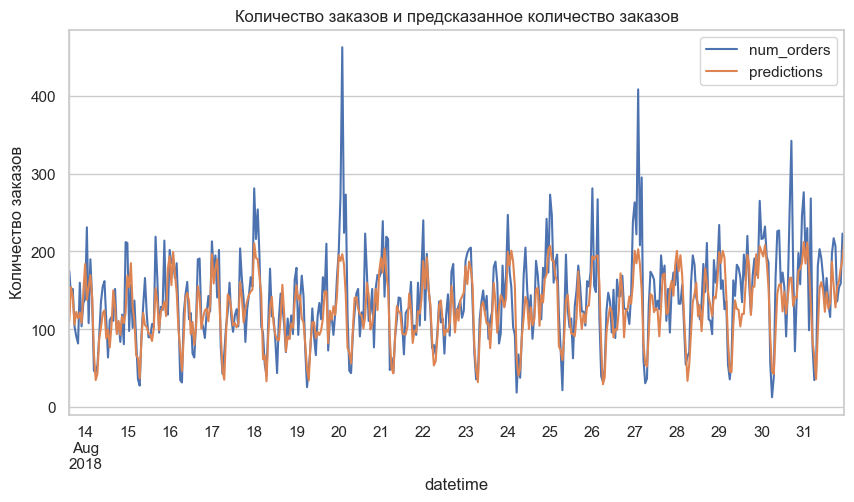

In [27]:
plt.figure(figsize=(10, 5))
test['predictions'] = predictions
test[['num_orders', 'predictions']].plot(ax=plt.gca())
plt.title('Количество заказов и предсказанное количество заказов')
plt.ylabel('Количество заказов')

Text(0, 0.5, 'Количество заказов')

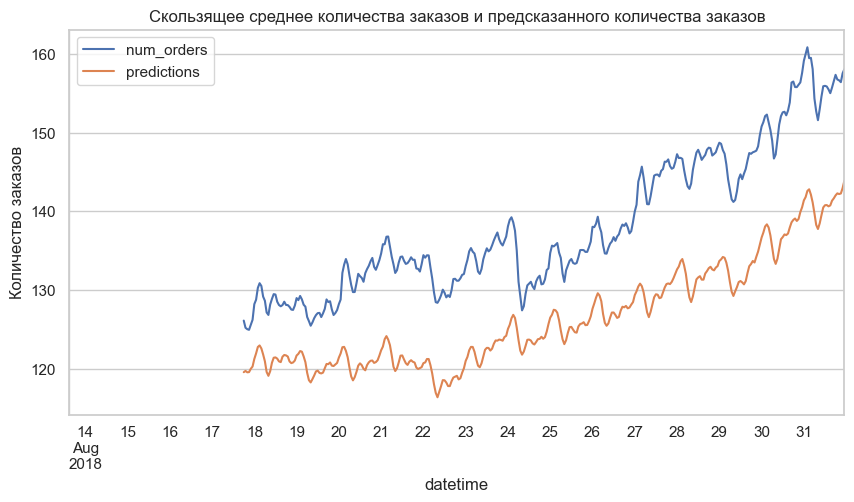

In [28]:
plt.figure(figsize=(10, 5))
test['predictions'] = predictions
roll_mean = test[['num_orders', 'predictions']].rolling(100).mean()
roll_mean.plot(ax=plt.gca())
plt.title('Скользящее среднее количества заказов и предсказанного количества заказов')
plt.ylabel('Количество заказов')

### Общие выводы

По полученным данным от сервиса такси была построена модель для предсказания количества заказов такси по часам. Лучшей моделью в результате кросс-валидации с перебором параметров оказалась LightgbmRegressor. Ее ошибка RMSE составляет 40.02 на тестовых данных. (хотя при кросс-валидации была ниже: 23.9). В дальнейшем ее можно будет улучшить, когда будут данные за несколько лет, так как по 3 месяцам не учесть, например, сезонность, что и вызвало отличие скользящего среднего количества тестовых заказов от предсказаний модели только в большую сторону.

Таким образом, рекомендуется использовать данную модель для прогноза спроса на такси.